## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow_graph_in_jupyter import show_graph

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

In [2]:
 print(tf.__version__) 

1.13.0-rc2


In [3]:
# To plot images
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [4]:
# To plot confusion matrix
# Source: https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7/
def confusion_matrix_plot(y_true, y_pred, filename, labels= range(10), ymap=None, figsize=(10,10), 
                          midpoint=500,color=None, v_min=0,v_max=1000):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, annot_kws={"size": 13}, 
                cmap=color, center=midpoint, vmin=v_min, vmax=v_max)       
    plt.savefig(filename)

## Get the Data

In [5]:
# import data
zalando_data_train = pd.read_csv('fashion-mnist_train.csv')
zalando_data_test = pd.read_csv('fashion-mnist_test.csv')

In [6]:
y_train_raw = zalando_data_train['label'].values
print(y_train_raw.shape)
X_train_raw = zalando_data_train.drop('label', axis=1).values
print(X_train_raw.shape)
y_test_raw = zalando_data_test['label'].values
print(y_test_raw.shape)
X_test_raw = zalando_data_test.drop('label', axis=1).values
print(X_test_raw.shape)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


In [7]:
print (zalando_data_train['label'].value_counts())

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64


Saving figure images_plot


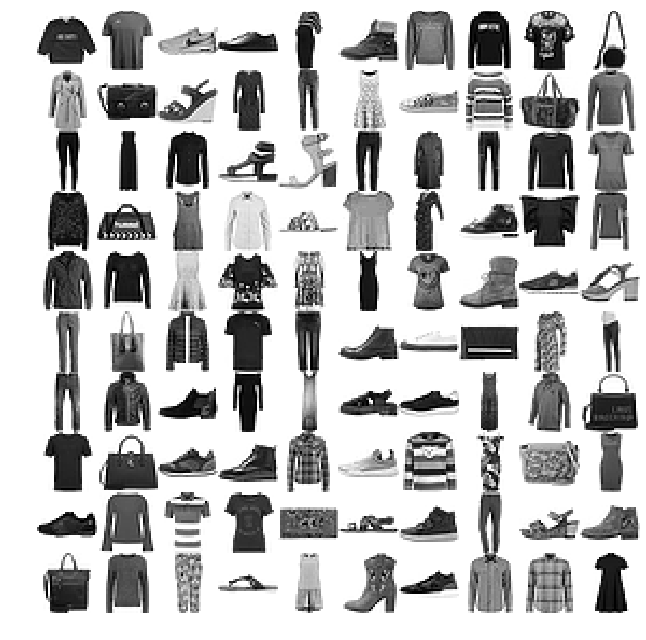

In [8]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_train_raw[:12000:600], X_train_raw[13000:30600:600], X_train_raw[30600:60000:590]]
plot_images(example_images, images_per_row=10)
save_fig("images_plot")
plt.show()

Saving figure images_for_each_label


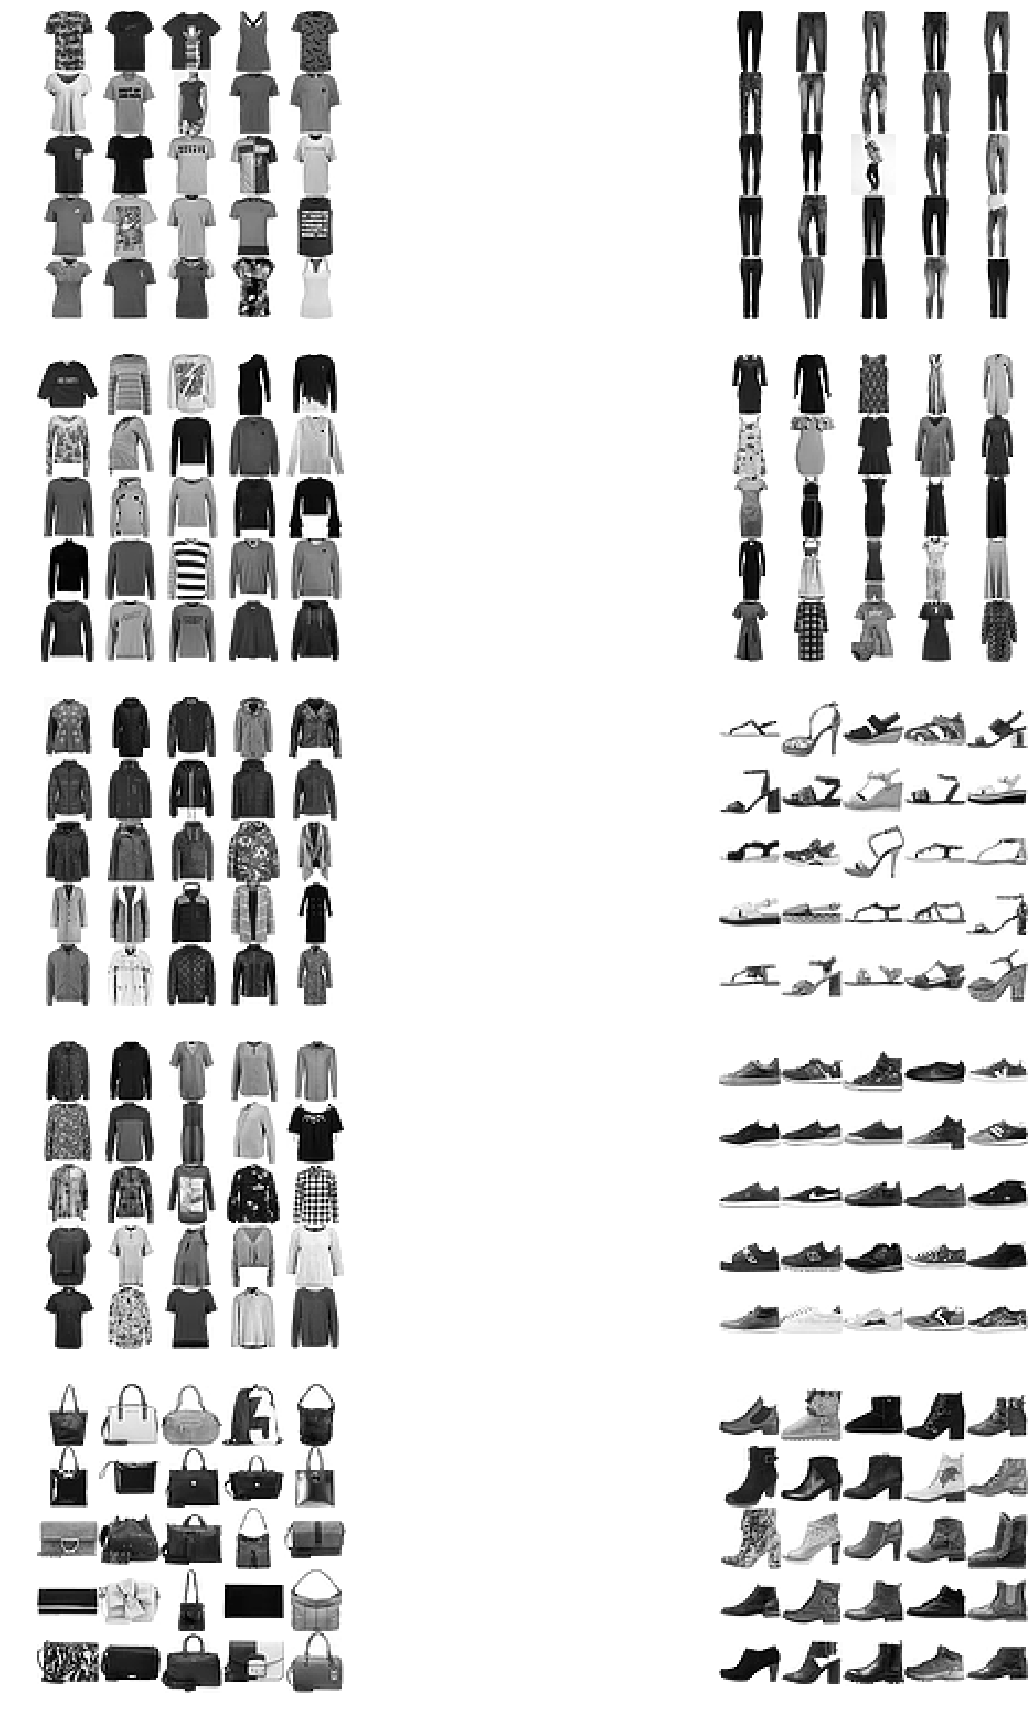

In [9]:
# plot images for each label
X_0 = X_train_raw[(y_train_raw == 0)]
X_1 = X_train_raw[(y_train_raw == 1)]
X_2 = X_train_raw[(y_train_raw == 2)]
X_3 = X_train_raw[(y_train_raw == 3)]
X_4 = X_train_raw[(y_train_raw == 4)]
X_5 = X_train_raw[(y_train_raw == 5)]
X_6 = X_train_raw[(y_train_raw == 6)]
X_7 = X_train_raw[(y_train_raw == 7)]
X_8 = X_train_raw[(y_train_raw == 8)]
X_9 = X_train_raw[(y_train_raw == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
save_fig("images_for_each_label")
plt.show()

## Linear Classifier

In [10]:
# prepare data
y_train = y_train_raw
X_train = X_train_raw
y_test = y_test_raw
X_test = X_test_raw

In [11]:
# prepare Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
logit_clf = LogisticRegression(tol=0.0001, C=1.0, random_state=42, solver='sag', 
                               max_iter=300, multi_class='multinomial')                                                      

In [12]:
# training and validation
logit_clf.fit(X_train, y_train) 
y_train_logit_pred = logit_clf.predict(X_train)
y_test_logit_pred = logit_clf.predict(X_test)

print("Training Accuracy",(y_train_logit_pred  == y_train).mean())
print("Test Accuracy",(y_test_logit_pred  == y_test).mean())

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy 0.8794166666666666
Test Accuracy 0.8462


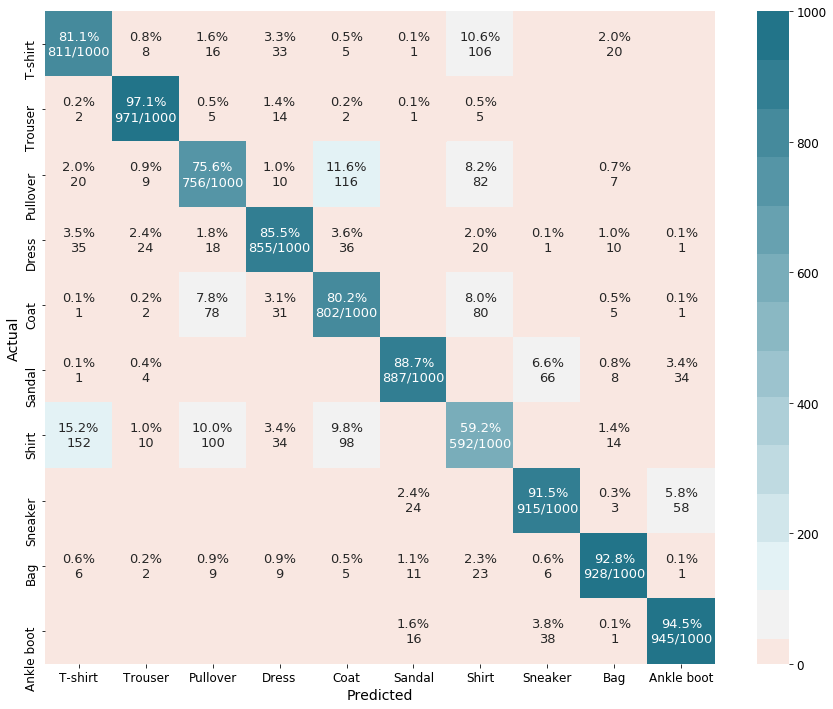

In [13]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_logit_pred, 
    filename="confusion_matrix_logit_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

In [14]:
# Linear SVM classfier
from sklearn.linear_model import SGDClassifier
sgd_svm_clf = SGDClassifier(max_iter=150, random_state=42,loss='hinge', tol=0.01)
sgd_svm_clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=150,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.01,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
# training and validation
y_train_sgd_svm_pred = sgd_svm_clf.predict(X_train)
y_test_sgd_svm_pred = sgd_svm_clf.predict(X_test)

print("Training Accuracy",(y_train_sgd_svm_pred == y_train).mean())
print("Test Accuracy",(y_test_sgd_svm_pred == y_test).mean())

Training Accuracy 0.8507833333333333
Test Accuracy 0.8304


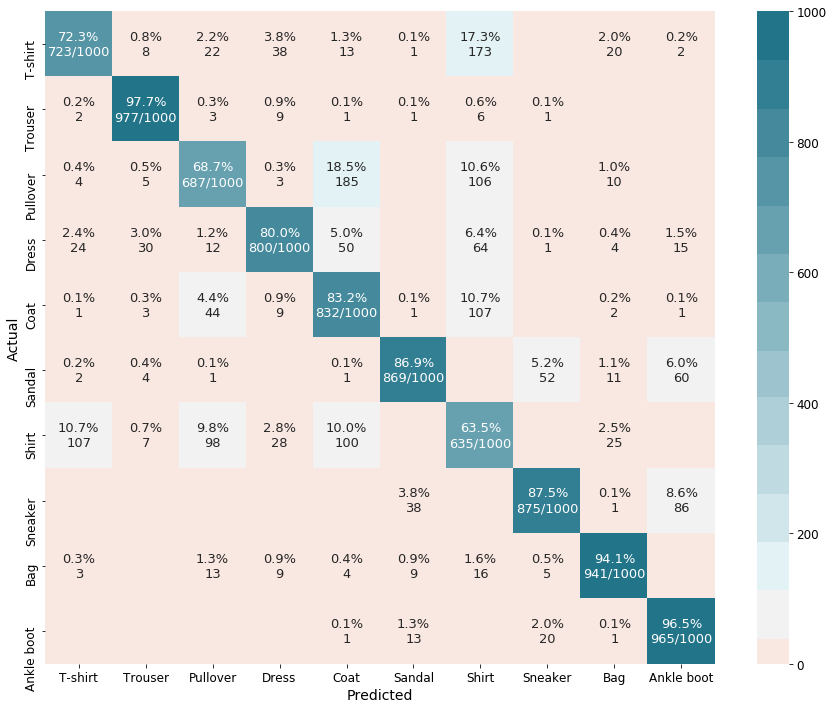

In [16]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_sgd_svm_pred, 
    filename="confusion_matrix_sgd_svm_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

### Linear SVM Classifier  (pre-processing: scaling)

In [17]:
# prepare classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

In [18]:
# training and validation
sgd_svm_clf = SGDClassifier(max_iter=150, random_state=42,loss='hinge', tol=0.0001)
sgd_svm_clf.fit(X_train_scaled, y_train)
y_train_svm_scaled_pred = sgd_svm_clf.predict(X_train_scaled)
y_test_svm_scaled_pred = sgd_svm_clf.predict(X_test_scaled)

print("Training Accuracy",(y_train_svm_scaled_pred == y_train).mean())
print("Test Accuracy",(y_test_svm_scaled_pred == y_test).mean())

Training Accuracy 0.8434833333333334
Test Accuracy 0.8361


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


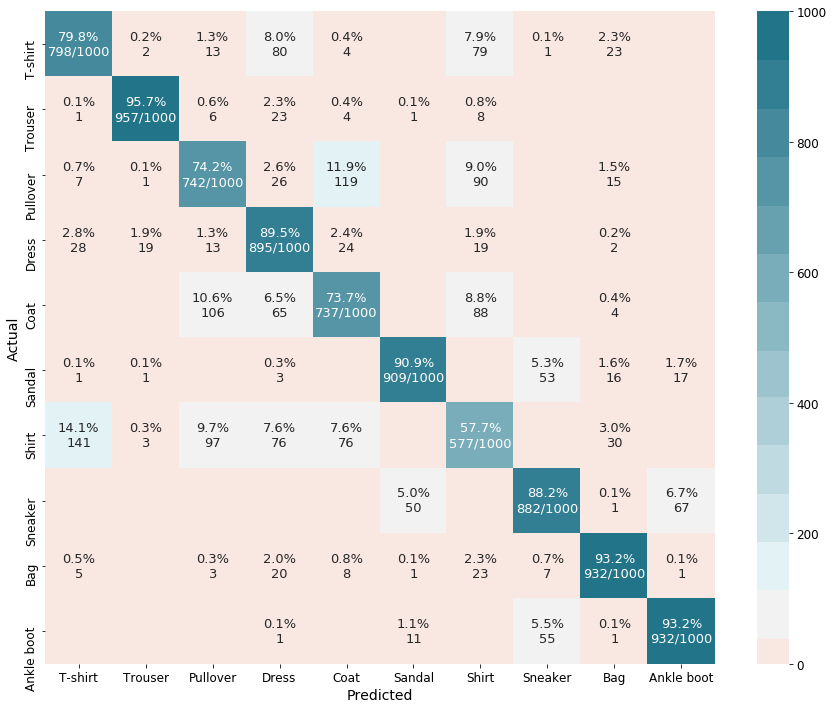

In [19]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_svm_scaled_pred, 
    filename="confusion_matrix_sgd_scaled_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

## Random Forest Classifier

In [42]:
# Data preparation
y_train = y_train_raw
X_train = X_train_raw
y_test = y_test_raw
X_test = X_test_raw

In [21]:
# Classifier preparation
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

# ovo_clf = OneVsOneClassifier(RandomForestClassifier(random_state=42)) # overfitting without max_depth setting
ovo_rf_clf = OneVsOneClassifier(RandomForestClassifier(random_state=42, max_depth = 20))

In [22]:
# Training and validation
ovo_rf_clf.fit(X_train, y_train)
y_train_rf_pred = ovo_rf_clf.predict(X_train)
y_test_rf_pred = ovo_rf_clf.predict(X_test)

print("Training Accuracy",(y_train_rf_pred == y_train).mean())
print("Test Accuracy",(y_test_rf_pred == y_test).mean())

Training Accuracy 0.9906666666666667
Test Accuracy 0.8631


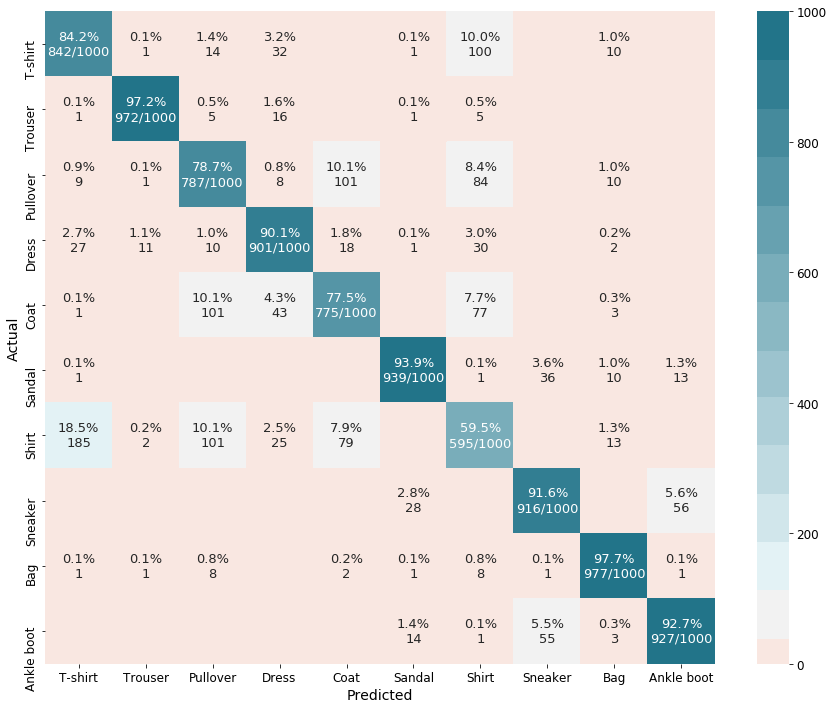

In [23]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_rf_pred,
    filename="confusion_matrix_rf_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

## CNN 

In [25]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [26]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "."    
logdir = "{}//run-{}//".format(root_logdir, now)

In [ ]:
# Building CNN architecture
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 64#16  
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 16 
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = 16#8

n_fc1 = 64#32 
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
file_writer = tf.summary.FileWriter(logdir , tf.get_default_graph())  # for TensorBoard

In [28]:
# Data preparation
X_train = X_train_raw.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test_raw.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train_raw.astype(np.int32)
y_test = y_test_raw.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_train.shape

(55000, 784)

In [29]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [30]:
# Trainning CNN model
n_epochs = 30
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)         
    saver.save(sess, "./fashion_mnist_cnn_model.ckpt")
        
file_writer.close() # for TensorBoard

0 Last batch accuracy: 0.77 Test accuracy: 0.8679
1 Last batch accuracy: 0.91 Test accuracy: 0.8842
2 Last batch accuracy: 0.87 Test accuracy: 0.8985
3 Last batch accuracy: 0.9 Test accuracy: 0.8928
4 Last batch accuracy: 0.95 Test accuracy: 0.9063
5 Last batch accuracy: 0.96 Test accuracy: 0.9054
6 Last batch accuracy: 0.95 Test accuracy: 0.9095
7 Last batch accuracy: 0.92 Test accuracy: 0.9142
8 Last batch accuracy: 0.95 Test accuracy: 0.9168
9 Last batch accuracy: 0.93 Test accuracy: 0.9149
10 Last batch accuracy: 0.98 Test accuracy: 0.9166
11 Last batch accuracy: 0.94 Test accuracy: 0.9168
12 Last batch accuracy: 0.98 Test accuracy: 0.9158
13 Last batch accuracy: 0.94 Test accuracy: 0.9126
14 Last batch accuracy: 0.98 Test accuracy: 0.9143
15 Last batch accuracy: 0.97 Test accuracy: 0.9114
16 Last batch accuracy: 0.93 Test accuracy: 0.9174
17 Last batch accuracy: 0.93 Test accuracy: 0.9182
18 Last batch accuracy: 0.93 Test accuracy: 0.9194
19 Last batch accuracy: 0.93 Test accuracy

In [31]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

In [32]:
# Validation on test set
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_cnn_model.ckpt")   
    Z = logits.eval(feed_dict={X: X_test})
    y_test_cnn_pred = np.argmax(Z, axis=1)

print("Test Accuracy",( y_test_cnn_pred == y_test).mean())# accuracy for test set

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./fashion_mnist_cnn_model.ckpt
Test Accuracy 0.9133


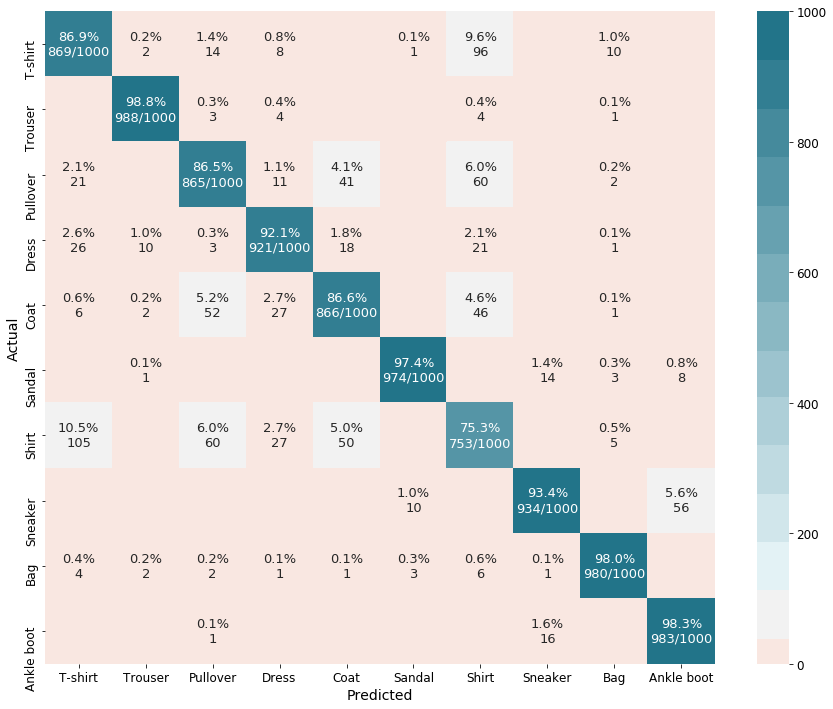

In [33]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_cnn_pred,
    filename="confusion_matrix_cnn_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

## Neural Nets

<p>The training time is too long and results we obtain is not that good.

In [61]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [62]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "."    
logdir = "{}//run-{}//".format(root_logdir, now)

In [63]:
#define validation and training sets
X_test = X_test.astype(np.int32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:100], X_train[100:]
y_valid, y_train = y_train[:100], y_train[100:]


n_inputs = 784  # number of features 
n_hidden1 = 147   
n_hidden2 = 70   
# dedfine more hidden layers
n_hidden3 = 50
n_outputs = 10 
tf.reset_default_graph()   # reset graph


# y place holder for output
# auxialrry variable 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
a = tf.placeholder(tf.float32,shape=(None),name='a')


summary1 = tf.reduce_mean(a, name="summary1")

#layer of network takes input of neurones  
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
 

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3", activation=tf.nn.relu)
    logits  = neuron_layer(hidden3, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

#learning rate - change if issues regrading convergence or others happen
learning_rate =1e-1
with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

#define accuracy 
with tf.name_scope("accuracy"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#leave this
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
from random import randint
n_epochs = 100  
batch_size = 100   

init = tf.global_variables_initializer()
saver = tf.train.Saver()


summary2 = tf.summary.scalar('Accuracy', summary1)
file_writer = tf.summary.FileWriter(logdir , tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print("Val accuracy init:", acc_val)
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)
        
        summary_str = summary2.eval(feed_dict={a: acc_val })
        file_writer.add_summary(summary_str, epoch)
   
    saver.save(sess, "./fashion_mnist_dnn_model.ckpt")   

In [65]:
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_dnn_model.ckpt")   
    Z = logits.eval(feed_dict={X: X_test})
    y_test_dnn_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./fashion_mnist_dnn_model.ckpt


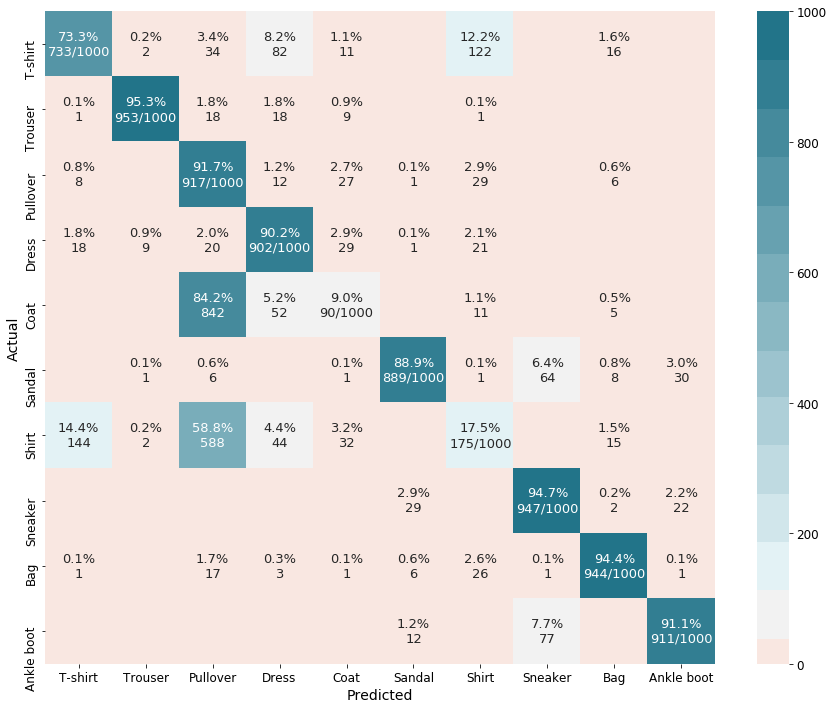

In [66]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_dnn_pred,
    filename="confusion_matrix_dnn_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

## RNN

<p>The training time is too long and results we obtain is not that good.

In [ ]:
import tensorflow as tf

reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150 
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)

prediction = tf.argmax(logits, 1)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1) # check if the prediction is corret [True, False]
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("FashionMnist-data")

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

In [69]:
import time
n_epochs = 10 
batch_size = 150
start_time = time.time()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # print(iteration,end=' ')
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Test accuracy:", acc_test)       
    saver.save(sess, "./fashion_mnist_rnn_model.ckpt")

print("--- %s seconds ---" % (time.time() - start_time))

0 Test accuracy: 0.7962
1 Test accuracy: 0.8149
2 Test accuracy: 0.8262
3 Test accuracy: 0.8335
4 Test accuracy: 0.8429
5 Test accuracy: 0.8333
6 Test accuracy: 0.8426
7 Test accuracy: 0.8494
8 Test accuracy: 0.8477
9 Test accuracy: 0.8537
--- 83.00638699531555 seconds ---


In [70]:
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_rnn_model.ckpt") 
    prediction = tf.argmax(logits, axis=1)
    y_test_rnn_pred = sess.run(prediction, feed_dict={X: X_test})

print("Test Accuracy",(y_test_rnn_pred == y_test).mean())# accuracy for test set

INFO:tensorflow:Restoring parameters from ./fashion_mnist_rnn_model.ckpt
Test Accuracy 0.8537


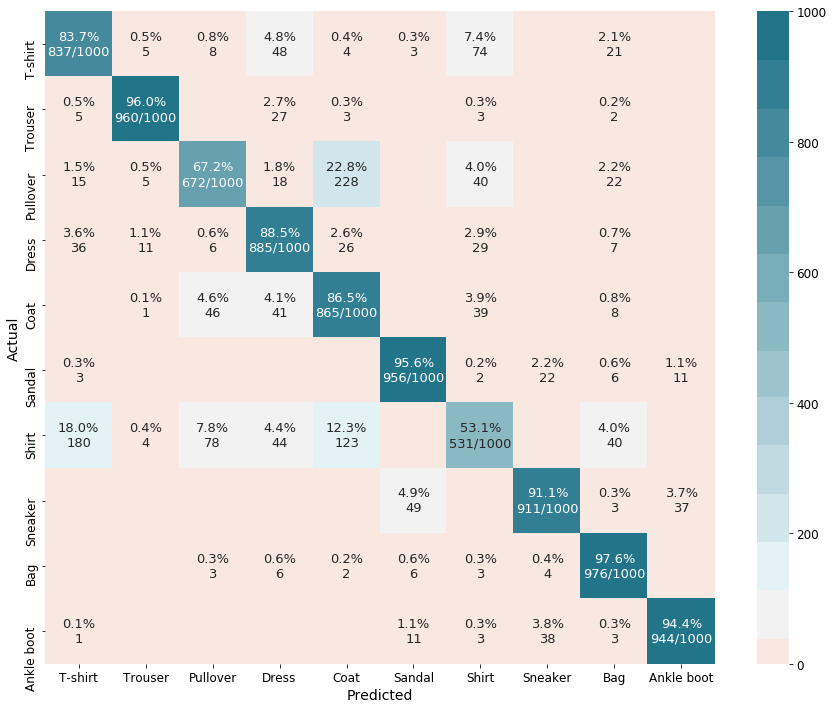

In [71]:
# Evaluating classifier 
confusion_matrix_plot(y_test, y_test_rnn_pred,
    filename="confusion_matrix_rnn_test",
    ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
    6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"},
    color=sns.diverging_palette(20,220, sep=10, n=25, s=90, l=45,center ='light'),
    midpoint=75,figsize=(15,12),v_min=0,v_max=1000)

## Error Analysis on training set for Logistic Regression Classifier

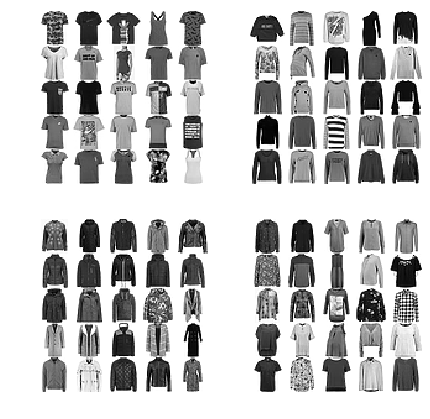

In [60]:
# more errors happend to label 0,2,4,6 
X_0 = X_train[(y_train == 0)]
X_2 = X_train[(y_train == 2)]
X_4 = X_train[(y_train == 4)]
X_6 = X_train[(y_train == 6)]

plt.figure(figsize=(7,7))
plt.subplot(221); plot_images(X_0[:25], images_per_row=5)
plt.subplot(222); plot_images(X_2[:25], images_per_row=5)
plt.subplot(223); plot_images(X_4[:25], images_per_row=5)
plt.subplot(224); plot_images(X_6[:25], images_per_row=5)
# save_fig("images_for_labels_0&2&4&6")

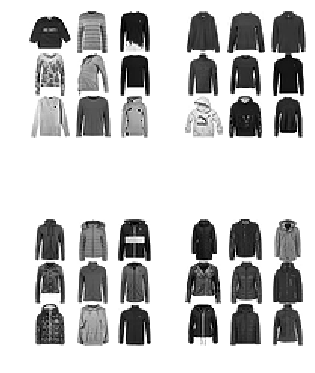

In [59]:
# error analysis : label 2 and 4
cl_a, cl_b = 2, 4
X_aa = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_b)]
plt.figure(figsize=(5,7))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_2&4")
plt.show()

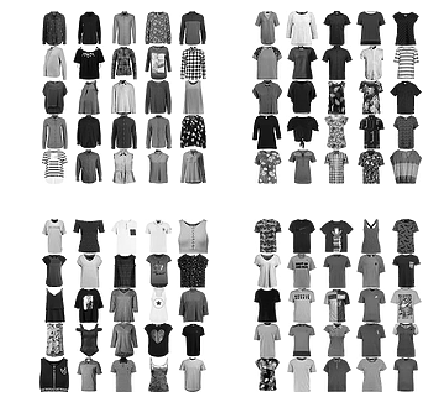

In [58]:
# error analysis : label 6 and 0
cl_a, cl_b = 6, 0
X_aa = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_b)]

plt.figure(figsize=(7,7))
plt.subplot(221); plot_images(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_images(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_images(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_images(X_bb[:25], images_per_row=5)
# save_fig("error_analysis_images_plot_6&0")
plt.show()

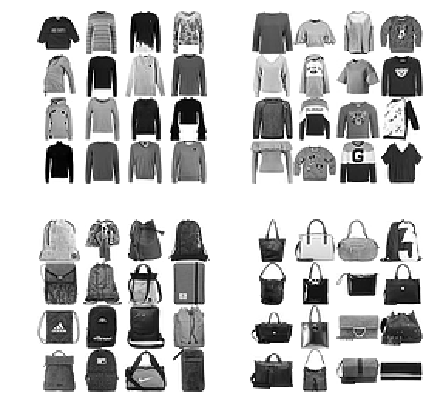

In [57]:
# error analysis : label 6 and 0
cl_a, cl_b = 2, 8
X_aa = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_logit_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_logit_pred == cl_b)]

plt.figure(figsize=(7,7))
plt.subplot(221); plot_images(X_aa[:16], images_per_row=4)
plt.subplot(222); plot_images(X_ab[:16], images_per_row=4)
plt.subplot(223); plot_images(X_ba[:16], images_per_row=4)
plt.subplot(224); plot_images(X_bb[:16], images_per_row=4)
# save_fig("error_analysis_images_plot_2&8")
plt.show()

## Error Analysis on training set for Logistic Regression Classifier

Saving figure images_for_labels_0&2&4&6


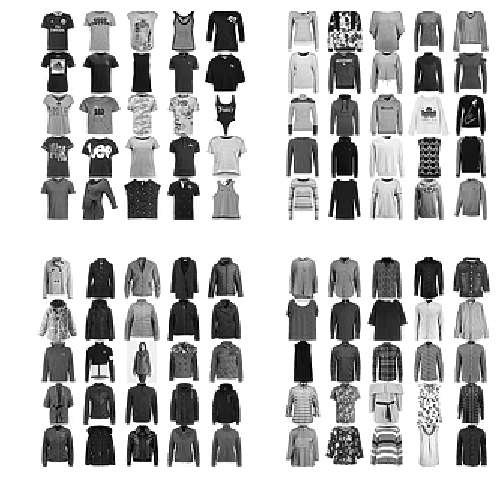

In [56]:
# more errors happend to label 0,2,4,6 
X_0 = X_test[(y_test == 0)]
X_2 = X_test[(y_test == 2)]
X_4 = X_test[(y_test == 4)]
X_6 = X_test[(y_test == 6)]

plt.figure(figsize=(7,7))
plt.subplot(221); plot_images(X_0[:25], images_per_row=5)
plt.subplot(222); plot_images(X_2[:25], images_per_row=5)
plt.subplot(223); plot_images(X_4[:25], images_per_row=5)
plt.subplot(224); plot_images(X_6[:25], images_per_row=5)
save_fig("images_for_labels_0&2&4&6")
plt.show()

Saving figure images_for_labels_5&7&9


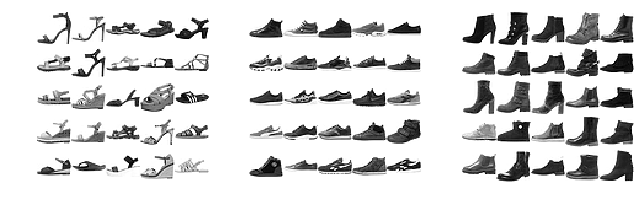

In [48]:
# more errors happend to label 5,7,9
X_5 = X_test[(y_test == 5)]
X_7 = X_test[(y_test == 7)]
X_9 = X_test[(y_test == 9)]

plt.figure(figsize=(9,9))
plt.subplot(131); plot_images(X_5[:25], images_per_row=5)
plt.subplot(132); plot_images(X_7[:25], images_per_row=5)
plt.subplot(133); plot_images(X_9[:25], images_per_row=5)
save_fig("images_for_labels_5&7&9")
plt.show()

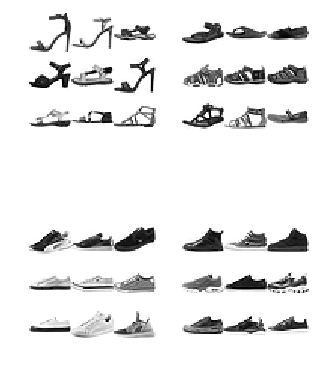

In [49]:
# error analysis : label 5 and 7
cl_a, cl_b = 5, 7
X_aa = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_b)]

plt.figure(figsize=(5,7))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_5&7")
plt.show()

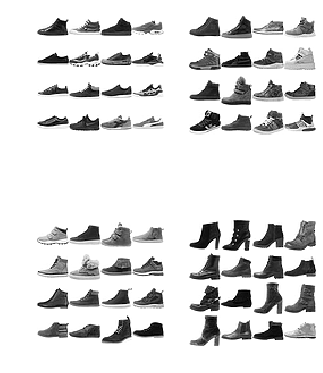

In [53]:
# error analysis : label 7 and 9
cl_a, cl_b = 7, 9
X_aa = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_b)]

plt.figure(figsize=(5,7))
plt.subplot(221); plot_images(X_aa[:16], images_per_row=4)
plt.subplot(222); plot_images(X_ab[:16], images_per_row=4)
plt.subplot(223); plot_images(X_ba[:16], images_per_row=4)
plt.subplot(224); plot_images(X_bb[:16], images_per_row=4)
# save_fig("error_analysis_images_plot_7&9")
plt.show()

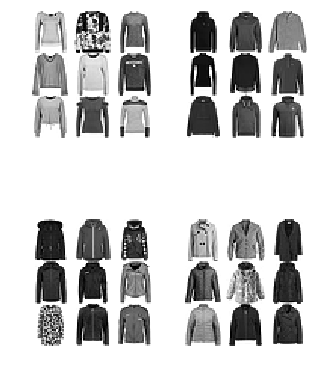

In [55]:
# error analysis : label 2 and 4
cl_a, cl_b = 2, 4
X_aa = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_b)]

plt.figure(figsize=(5,7))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_2&4")
plt.show()

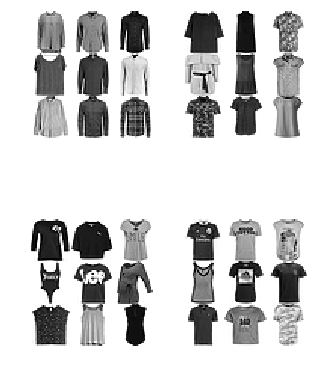

In [54]:
# error analysis : label 6 and 0
cl_a, cl_b = 6, 0
X_aa = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_logit_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_logit_pred == cl_b)]

plt.figure(figsize=(5,7))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_6&0")
plt.show()